# Calibration of dgemm

Here, we will take as a model:

$T(m, n, k) = \alpha + \beta mn + \gamma mk + \delta nk + \zeta mnk + |\mathcal{N}(0, \sigma(m, n, k)|$

Where the noise parameter has itself a model:
$\sigma(m, n, k) = \eta + \theta mn + \lambda mk + \nu nk + \rho mnk$

In a first time, we will take a normal noise and not a half-normal, since it should be easier.

## Half-Normal noise

In [1]:
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
import pystan
import matplotlib.pyplot as plt
import numpy
import statsmodels.formula.api as st
warnings.simplefilter(action='ignore', category=FutureWarning)

def get_sizes(N, target_product):
    '''
    Return a list of N random sizes such that their product is close to the target (would be exactly the target without the rounding).
    Warning: the tuple is biased, only the last size can be greater than target_product**(1/N).
    '''
    if N == 1:
        return [target_product]
    s = round(numpy.random.uniform(1, target_product**(1/N)))
    return [s] + get_sizes(N-1, round(target_product/s))

def generate_polynomial_fit(intercept, coeff_mn, coeff_mk, coeff_nk, coeff_mnk, N=1000, max_prod=1e10, seed=42):
    numpy.random.seed(seed)
    df = []
    products = [int(10**numpy.random.uniform(1, 10.3)) for _ in range(N)]
    for max_prod in products:
        sizes = get_sizes(3, max_prod)
        numpy.random.shuffle(sizes)
        m, n, k = sizes
        df.append({
            'm': m,
            'n': n,
            'k': k,
            'mnk': m*n*k,
            't': intercept + coeff_mn*m*n + coeff_mk*m*k + coeff_nk*n*k + coeff_mnk*m*n*k
        })
    return pandas.DataFrame(df)

def generate_dataset(params_raw, params_noise, halfnormal=False, seed=42):
    df = generate_polynomial_fit(*params_raw, seed=seed)
    noise_sigma = generate_polynomial_fit(*params_noise, seed=seed)
    noise_sigma['noise'] = numpy.random.normal(0, 1, len(noise_sigma))
    if halfnormal:
        noise_sigma['noise'] = numpy.abs(noise_sigma['noise'])
    noise_sigma.head()
    noise_sigma['noise'] *= noise_sigma['t']
    df['t'] += noise_sigma['noise']
    return df

df = generate_dataset(
        params_raw = (3e-7, 1.4e-10, 2.1e-9, 3.3e-9, 6.3e-11),
        params_noise = (1e-7, 8.3e-12, 1.5e-10, 9.9e-11, 2.9e-12),
        halfnormal=True,
)

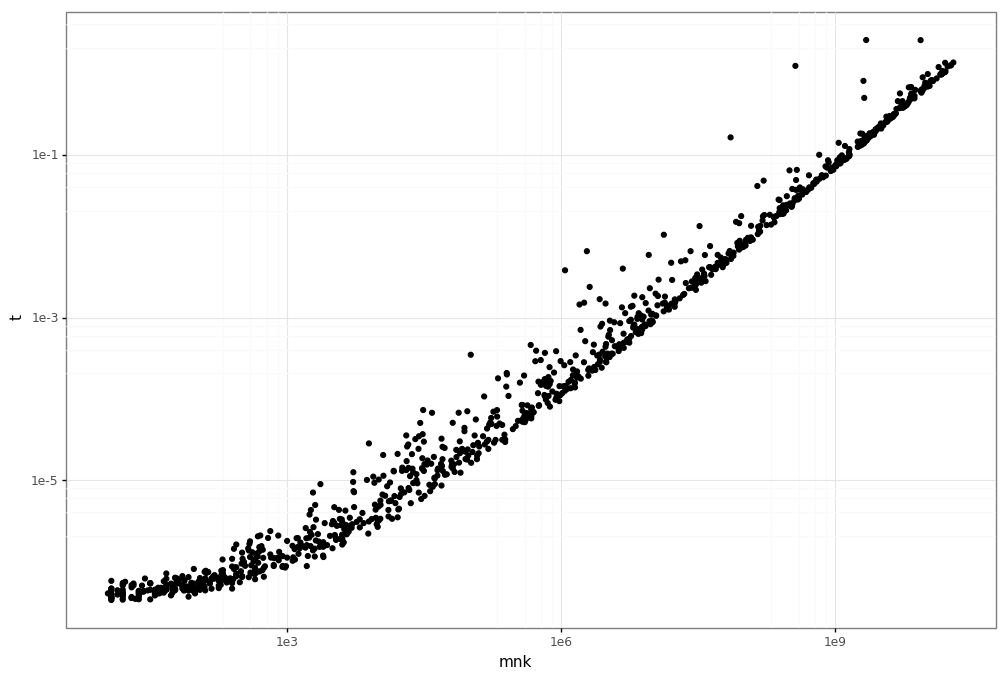

<ggplot: (8733333716330)>

In [2]:
ggplot(df, aes(x='mnk', y='t')) + geom_point() + theme_bw() + scale_x_log10() + scale_y_log10()

In [3]:
%%time

model_code = """
data {
    int<lower=1> nb_points;
    vector<lower=0>[nb_points] M; // real X[N] does not work
    vector<lower=0>[nb_points] N;
    vector<lower=0>[nb_points] K;
    vector<lower=0>[nb_points] T;
}
transformed data {
  vector<lower=0>[nb_points] MN =  M .* N; // element-wise product
  vector<lower=0>[nb_points] MK =  M .* K;
  vector<lower=0>[nb_points] NK =  N .* K;
  vector<lower=0>[nb_points] MNK = M .* N .* K;
}
parameters {
    real<lower=0> intercept;
    real<lower=0> coeff_mn;
    real<lower=0> coeff_mk;
    real<lower=0> coeff_nk;
    real<lower=0> coeff_mnk;

    real<lower=0> intercept_noise;
    real<lower=0> coeff_mn_noise;
    real<lower=0> coeff_mk_noise;
    real<lower=0> coeff_nk_noise;
    real<lower=0> coeff_mnk_noise;
}
model {
    intercept        ~ normal(0, 1e-5);
    coeff_mn         ~ normal(0, 1e-5);
    coeff_mk         ~ normal(0, 1e-5);
    coeff_nk         ~ normal(0, 1e-5);
    coeff_mnk        ~ normal(0, 1e-5);
    intercept_noise  ~ normal(0, 1e-5);
    coeff_mn_noise   ~ normal(0, 1e-5);
    coeff_mk_noise   ~ normal(0, 1e-5);
    coeff_nk_noise   ~ normal(0, 1e-5);
    coeff_mnk_noise  ~ normal(0, 1e-5);

    for (i in 1:nb_points) {
        if(T[i]            >=            intercept       + coeff_mn*MN[i]       + coeff_mk*MK[i]       + coeff_nk*NK[i]       + coeff_mnk*MNK[i]) {
            target += normal_lpdf(T[i] | intercept       + coeff_mn*MN[i]       + coeff_mk*MK[i]       + coeff_nk*NK[i]       + coeff_mnk*MNK[i],
                                         intercept_noise + coeff_mn_noise*MN[i] + coeff_mk_noise*MK[i] + coeff_nk_noise*NK[i] + coeff_mnk_noise*MNK[i]);
        }
        else {
            target += negative_infinity();
        }
    }
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9a90cdbd9d7e44df09ca7e26c347d4a4 NOW.


CPU times: user 842 ms, sys: 41.6 ms, total: 884 ms
Wall time: 53.2 s


Inference for Stan model: anon_model_9a90cdbd9d7e44df09ca7e26c347d4a4.
8 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=8000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
intercept       3.0e-7 4.7e-112.7e-10 3.0e-7 3.0e-7 3.0e-7 3.0e-7 3.0e-7     34   1.26
coeff_mn       1.4e-10 2.1e-134.3e-131.4e-101.4e-101.4e-101.4e-101.4e-10      4   4.75
coeff_mk        2.1e-9 2.3e-131.3e-12 2.1e-9 2.1e-9 2.1e-9 2.1e-9 2.1e-9     34   1.29
coeff_nk        3.3e-9 1.9e-131.4e-12 3.3e-9 3.3e-9 3.3e-9 3.3e-9 3.3e-9     58   1.17
coeff_mnk      6.3e-11 3.4e-151.2e-146.3e-116.3e-116.3e-116.3e-116.3e-11     12   1.29
intercept_noise10.0e-8 1.3e-103.2e-10 9.9e-810.0e-810.0e-8 1.0e-7 1.0e-7      6   3.59
coeff_mn_noise 8.3e-12 1.4e-143.1e-148.2e-128.3e-128.3e-128.3e-128.3e-12      4   4.82
coeff_mk_noise 1.5e-10 1.9e-134.4e-131.5e-101.5e-101.5e-101.5e-101.5e-10      5   3.66
coeff_nk_noise 9.9e-11 1.8e-

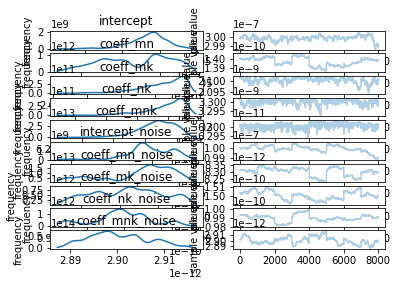

In [4]:
%%time

def init_func():
    return dict(
        intercept         = 3e-7,
        coeff_mn          = 1.4e-10,
        coeff_mk          = 2.1e-9,
        coeff_nk          = 3.3e-9,
        coeff_mnk         = 6.3e-11,
        intercept_noise   = 1e-7,
        coeff_mn_noise    = 8.3e-12,
        coeff_mk_noise    = 1.5e-10,
        coeff_nk_noise    = 9.9e-11,
        coeff_mnk_noise   = 2.9e-12,
    )

data=dict(nb_points=len(df), M=df['m'], N=df['n'], K=df['k'], T=df['t'])

fit = sm.sampling(data=data, iter=2000, chains=8, init=init_func, control=dict(adapt_delta=0.95))

print(fit)

fit.plot()

In [5]:
def get_generated_data(fit):
    fit = fit.extract()
    return (
        (fit['intercept'].mean(), fit['coeff_mn'].mean(), fit['coeff_mk'].mean(), fit['coeff_nk'].mean(), fit['coeff_mnk'].mean()),
        (fit['intercept_noise'].mean(), fit['coeff_mn_noise'].mean(), fit['coeff_mk_noise'].mean(), fit['coeff_nk_noise'].mean(), fit['coeff_mnk_noise'].mean())
    )

params = get_generated_data(fit)
params

((2.9983065098659976e-07,
  1.396896056354988e-10,
  2.1004806326662226e-09,
  3.2998368888180657e-09,
  6.300758997191115e-11),
 (9.994841372713839e-08,
  8.301524760488315e-12,
  1.5010040737855676e-10,
  9.89707883370194e-11,
  2.900383129416305e-12))

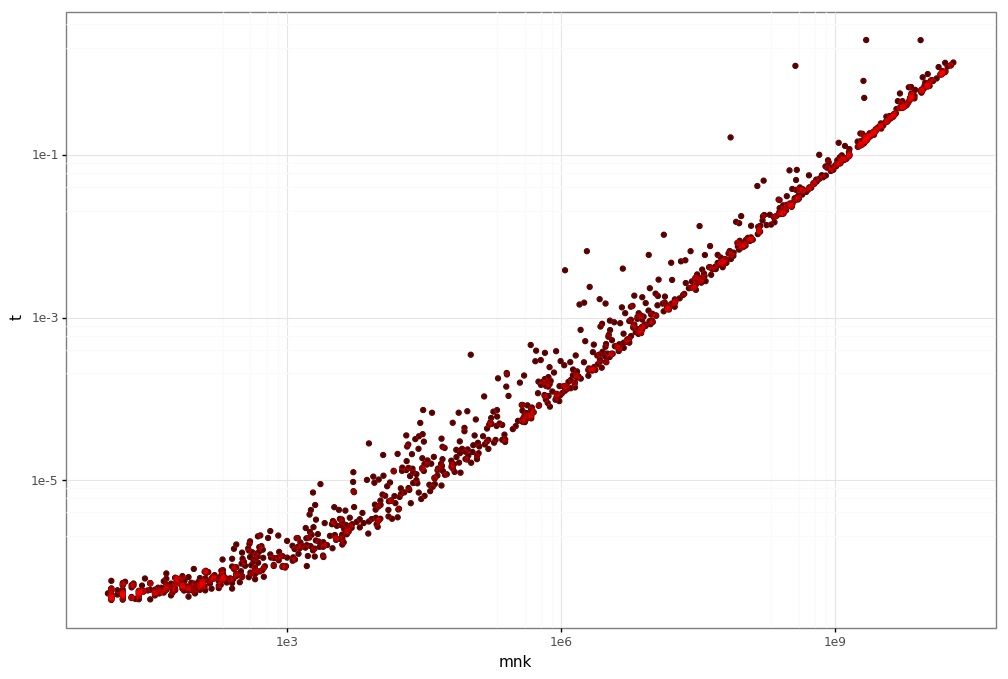

<ggplot: (-9223363303621995909)>

In [6]:
reg = generate_dataset(*params, halfnormal=True)
ggplot(df, aes(x='mnk', y='t')) + geom_point() + geom_point(data=reg, color='red', alpha=0.3) + theme_bw() + scale_x_log10() + scale_y_log10()

In [7]:
reg['t'].describe()

count    1.000000e+03
mean     7.209320e-02
std      2.305054e-01
min      3.380025e-07
25%      1.583020e-06
50%      8.166441e-05
75%      7.642603e-03
max      2.603355e+00
Name: t, dtype: float64

In [8]:
df['t'].describe()

count    1.000000e+03
mean     7.208680e-02
std      2.304900e-01
min      3.381705e-07
25%      1.583258e-06
50%      8.165815e-05
75%      7.641199e-03
max      2.603469e+00
Name: t, dtype: float64